In [48]:
import numpy as np
from scipy.stats import pearsonr

import NPI

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import numpy as np

def add_noise_to_target_snr(X_clean, target_snr_ratio=10.0, mode="even", rng=42):
    """
    X_clean: array with shape (T, R) or (N, T, R) where last axis = regions
    target_snr_ratio: signal_std / noise_std (e.g., 10=high SNR, 5=medium, 2=low)
    mode: "even" (same SNR for all regions) or "uneven" (region-wise variation)
    """
    rs = np.random.default_rng(rng)
    X = np.array(X_clean, dtype=np.float32)

    # std over all non-region axes
    region_axis = -1
    sig_std = X.std(axis=tuple(i for i in range(X.ndim) if i != region_axis), keepdims=True) + 1e-8

    if mode == "even":
        noise_std = sig_std.mean() / float(target_snr_ratio)
        noise = rs.normal(0.0, 1.0, size=X.shape).astype(np.float32) * noise_std
    else:
        # uneven: per-region multiplier ~ U[0.6, 1.4] around the target
        mult_shape = [1] * (X.ndim - 1) + [X.shape[region_axis]]
        mult = rs.uniform(0.6, 1.4, size=mult_shape).astype(np.float32)
        noise_std = (sig_std / float(target_snr_ratio)) * mult
        noise = rs.normal(0.0, 1.0, size=X.shape).astype(np.float32) * noise_std

    X_noisy = X + noise
    return X_noisy

def empirical_snr_ratio(X_clean, X_noisy):
    """Returns per-region SNR = std(signal)/std(noise)."""
    noise = X_noisy - X_clean
    num = X_clean.std(axis=tuple(i for i in range(X_clean.ndim-1)), keepdims=False)
    den = noise.std(axis=tuple(i for i in range(noise.ndim-1)), keepdims=False) + 1e-8
    return num / den  # shape: (regions,)


In [50]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"
    
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    
    return np.array(flattened)

### **NPI usage demo**

In [51]:
batch_size              = 50
train_set_proportion    = 0.8
ROI_num                 = 20
using_steps             = 3

In [52]:
signals = np.loadtxt('./RNN_simulation_data/sim_data/dynamics_020nodes_8000steps_00seed.txt')
SC      = np.loadtxt('./RNN_simulation_data/sim_data/SC_020nodes_8000steps_00seed.txt')
real_EC = np.loadtxt('./RNN_simulation_data/sim_data/real_EC_020nodes_8000steps_00seed.txt')

In [53]:
# === SNR/noise injection (RNN) ===
# Choose SNR level: high=10, medium=5, low=2 (you can tweak)
target_snr = 2.0      # change to 5.0 or 2.0 in different runs
noise_mode = "even"    # "even" or "uneven"
seed = 1              # fix seed for reproducibility; change if you want multiple repeats

signals_noisy = add_noise_to_target_snr(signals, target_snr_ratio=target_snr, mode=noise_mode, rng=seed)

# quick check: median SNR across regions
snr_vec = empirical_snr_ratio(signals, signals_noisy)
print("Empirical median SNR:", np.median(snr_vec))

# redirect the pipeline to use the noisy signals
signals = signals_noisy


Empirical median SNR: 1.9773292206352227


##### train NN

Several ANNs (MLP, CNN, RNN, VAR) are provided in the NPI framework, which can be used as a surrogate brain.

In [54]:
inputs, targets = NPI.multi2one(signals, steps = using_steps)

ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
# ANN = NPI.ANN_CNN(in_channels = ROI_num, hidden_channels = 3 * ROI_num, out_channels = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_RNN(input_dim = ROI_num, hidden_dim = int(2.5 * ROI_num), latent_dim = int(2.5 * ROI_num), output_dim = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_VAR(input_dim = using_steps * ROI_num, output_dim = ROI_num)

ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, batch_size, train_set_proportion, num_epochs = 80, lr = 2e-4, l2 = 5e-5)

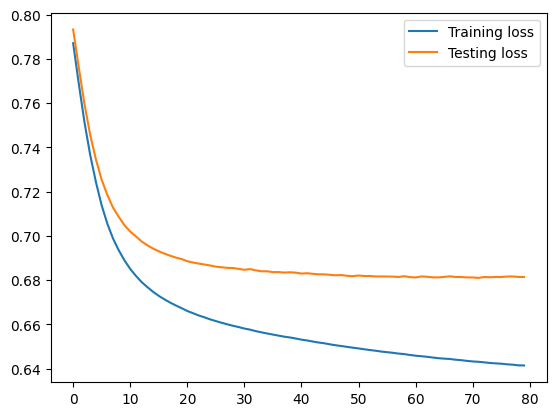

In [55]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

##### calculate empirical FC & model FC

In [56]:
empirical_FC = NPI.corrcoef(signals)
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

##### calculate NPI Inferred EC

In [57]:
NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
np.fill_diagonal(NPI_EC, 0)

##### calculate model Jacobian

In [58]:
NPI_Jacobian = NPI.model_Jacobian(ANN, inputs, steps = using_steps)
np.fill_diagonal(NPI_Jacobian, 0)

##### empirical FC - model FC comparison

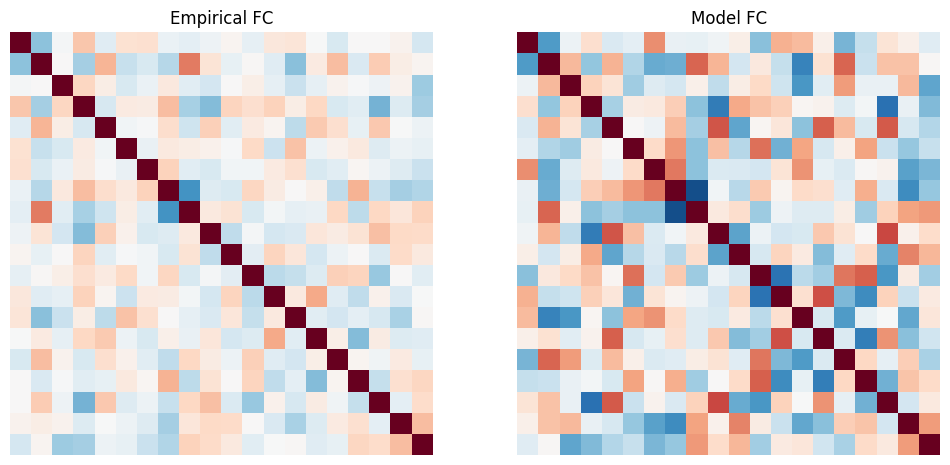

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC, ax = ax1, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

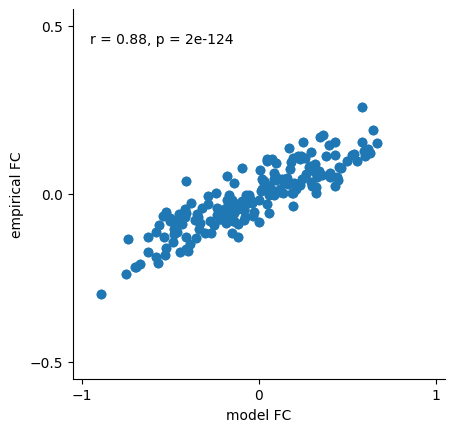

In [60]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-1.05, 1.05); plt.xticks([-1.0, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.55, 0.55); plt.yticks([-0.5, 0.0, 0.5]); plt.ylabel('empirical FC')
plt.text(-0.95, 0.45, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - NPI EC comparison

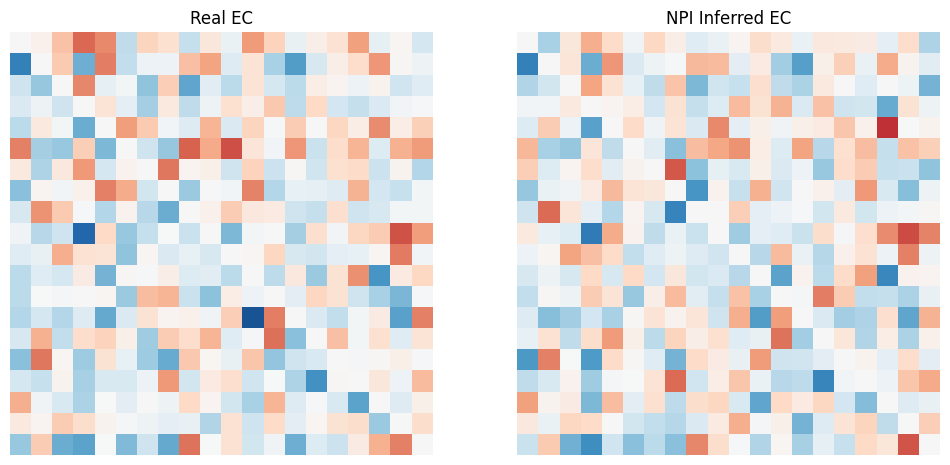

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('NPI Inferred EC')
plt.show()

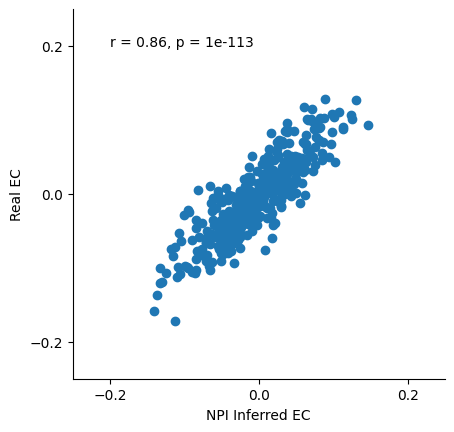

In [62]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.25, 0.25); plt.yticks([-0.2, 0.0, 0.2]); plt.ylabel('Real EC')
plt.text(-0.2, 0.2, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - model Jacobian comparison

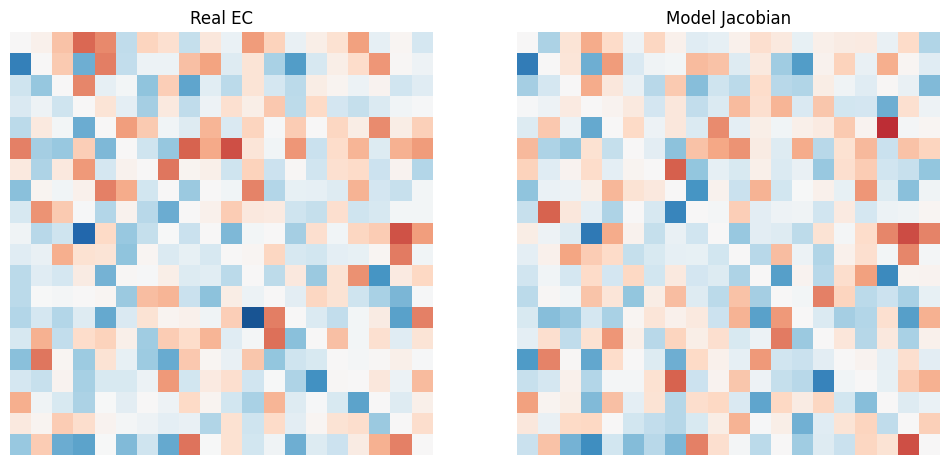

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_Jacobian, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('Model Jacobian')
plt.show()

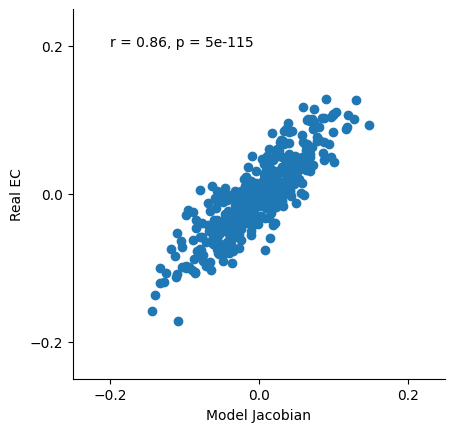

In [64]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('Model Jacobian')
plt.ylim(-0.25, 0.25); plt.yticks([-0.2, 0.0, 0.2]); plt.ylabel('Real EC')
plt.text(-0.2, 0.2, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### SC - NPI EC comparison

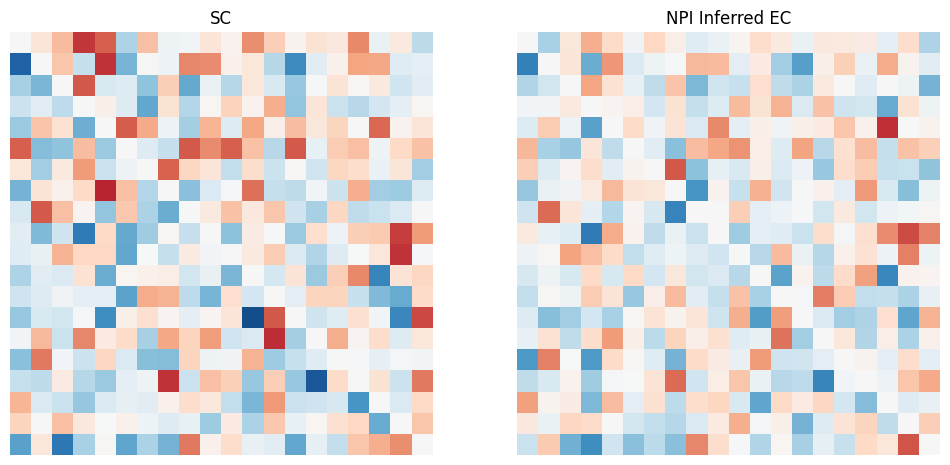

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(SC, ax = ax1, vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('SC'); ax2.set_title('NPI Inferred EC')
plt.show()

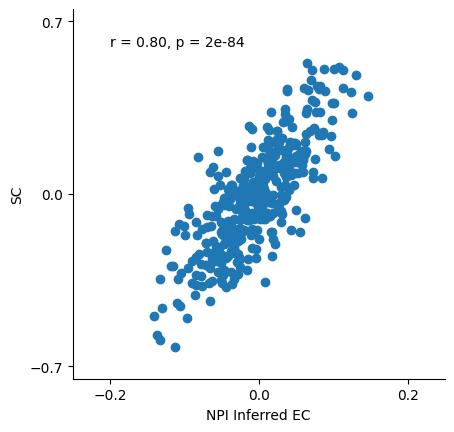

In [66]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.75, 0.75); plt.yticks([-0.7, 0.0, 0.7]); plt.ylabel('SC')
plt.text(-0.2, 0.6, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### Group-level analysis

In [67]:
NPIFC_empiricalFC_corr = []
NPIEC_realEC_corr = []
NPIEC_SC_corr = []

for i in range(50):

    signals = np.loadtxt('./RNN_simulation_data/sim_data/dynamics_020nodes_8000steps_{:02d}seed.txt'.format(i))
    SC      = np.loadtxt('./RNN_simulation_data/sim_data/SC_020nodes_8000steps_{:02d}seed.txt'.format(i))
    real_EC = np.loadtxt('./RNN_simulation_data/sim_data/real_EC_020nodes_8000steps_{:02d}seed.txt'.format(i))

    inputs, targets = NPI.multi2one(signals, steps = 3)
    ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
    ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, num_epochs = 80, lr = 2e-4, l2 = 5e-5)

    empirical_FC = NPI.corrcoef(signals)
    model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = 3)
    NPIFC_empiricalFC_corr.append(pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))[0])

    NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
    np.fill_diagonal(NPI_EC, 0)
    NPIEC_realEC_corr.append(pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))[0])
    NPIEC_SC_corr.append(pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))[0])

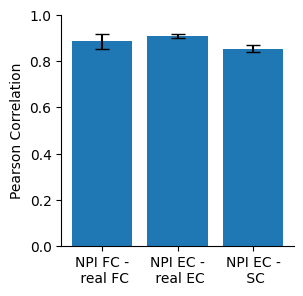

In [68]:
categories = ['NPI FC -\n real FC', 'NPI EC -\n real EC', 'NPI EC -\n SC']
values = [np.mean(NPIFC_empiricalFC_corr), np.mean(NPIEC_realEC_corr), np.mean(NPIEC_SC_corr)]
stds = [np.std(NPIFC_empiricalFC_corr), np.std(NPIEC_realEC_corr), np.std(NPIEC_SC_corr)]

plt.figure(figsize = (3, 3))
plt.bar(categories, values, yerr = stds, capsize = 5)
plt.ylabel('Pearson Correlation')
plt.ylim(0, 1)

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

In [69]:
import pandas as pd, os

# EXAMPLE: replace these with the actual variables you see printed above
metric_name = "fc_corr"   # or "ec_corr" / "jacobian_corr" etc.
metric_value = float(r_value)  # the variable used in the correlation section

row = {
    "demo": "RNN",       # or "WBM"
    "snr": target_snr,
    "mode": noise_mode,
    "seed": seed,
    "metric": metric_name,
    "value": metric_value,
}

out_csv = "RNNresults_snr_sweep.csv"
pd.DataFrame([row]).to_csv(out_csv, mode="a", index=False, header=not os.path.exists(out_csv))
print("Appended to", out_csv, row)

Appended to RNNresults_snr_sweep.csv {'demo': 'RNN', 'snr': 2.0, 'mode': 'even', 'seed': 1, 'metric': 'fc_corr', 'value': 0.7960184586401748}


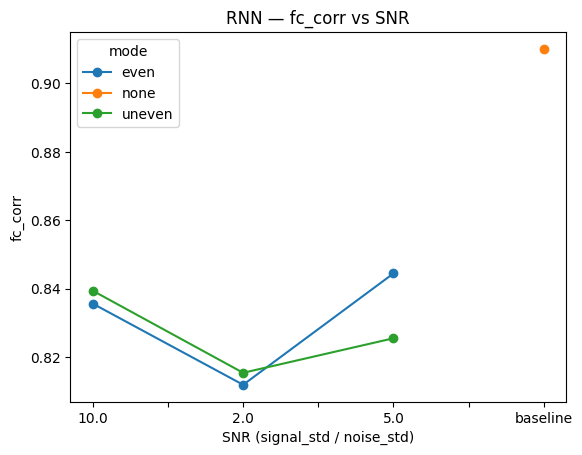

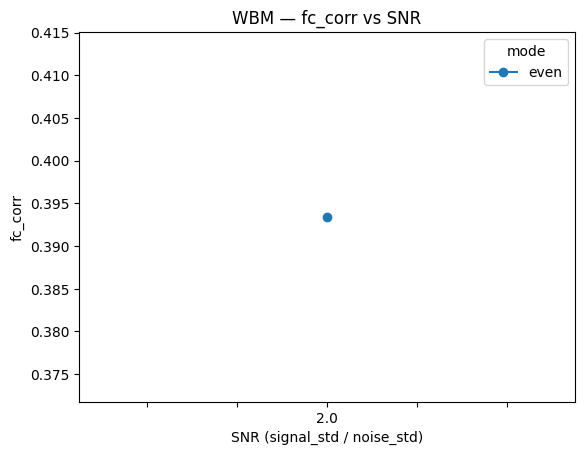

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_snr_sweep.csv")
for m in df["metric"].unique():
    d = df[df["metric"] == m]
    # average over seeds if you ran multiple seeds
    g = d.groupby(["demo","snr","mode"])["value"].mean().reset_index()

    for demo in g["demo"].unique():
        gd = g[g["demo"] == demo]
        # wide format for simple plotting
        pivot = gd.pivot(index="snr", columns="mode", values="value").sort_index()
        pivot.plot(marker="o", title=f"{demo} — {m} vs SNR")
        plt.xlabel("SNR (signal_std / noise_std)")
        plt.ylabel(m)
        plt.show()